# Loading Data, Packages

In [89]:
# loading packages
import pandas as pd
import numpy as np
import re

# load spambase dataset
df=pd.read_csv(r"C:\Users\Jent\Documents\College\Emory\Machine Learning II\Assignment 3\spambase.data",header=None)

In [197]:
# turning off warnings for better readability
import warnings
warnings.filterwarnings('ignore') #'ignore' to turn warnings off, 'default' to restore 

In [75]:
# getting column names
with open(r"C:\Users\Jent\Documents\College\Emory\Machine Learning II\Assignment 3\spambase.names") as f:
    lines = f.readlines()

# initialize empty list
newlist = []
for x in lines:
     split_results = x.split(':')
     newlist.append(split_results[0])

colnames=[x for x in newlist if x.startswith(('w', 'c'))]
colnames.append('spam')

In [95]:
# adding column names to df
df.columns=colnames

In [183]:
df.columns

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


In [187]:
# renaming columns due to errors in modeling stage
df=df.rename(columns={'char_freq_;':'char_freq_semi_colon',
                   'char_freq_(':'char_freq_paren',
                  'char_freq_[':'char_freq_bracket'})

## EDA
Spam=1, Non-Spam=0

In [97]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [105]:
# count of target variable
df.spam.value_counts()

0    2788
1    1813
Name: spam, dtype: int64

In [106]:
df.spam.value_counts(normalize=True)

0    0.605955
1    0.394045
Name: spam, dtype: float64

### Commentary
There is a class imbalance between spam and not spam which may need addressing

In [104]:
# comparing mean of features by spam/not spam
df.groupby('spam').mean()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
spam,,,,,,,,,,,,,,,,,,,,,
0,0.073479,0.244466,0.200581,0.000886,0.181040,0.044544,0.009383,0.038415,0.038049,0.167170,...,0.051227,0.050281,0.158578,0.022684,0.109984,0.011648,0.021713,2.377301,18.214491,161.470947
1,0.152339,0.164650,0.403795,0.164672,0.513955,0.174876,0.275405,0.208141,0.170061,0.350507,...,0.002101,0.020573,0.108970,0.008199,0.513713,0.174478,0.078877,9.519165,104.393271,470.619415


In [107]:
# checking for nulls
df.isnull().values.any()

False

In [114]:
# checking for duplicate rows
print(np.round(df.duplicated().sum()/len(df),2), 'percent of the data are duplicate rows')

0.08 percent of the data are duplicate rows


## Data Cleaning

In [115]:
# dropping duplicate rows
df=df.drop_duplicates()

# Modeling: Highest Overall Accuracy


In [124]:
# Imports for modeling
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
# shuffling dataframe so that it is not ordered by spam/not spam
df = df.sample(frac=1).reset_index(drop=True)

In [193]:
# Setting features, target variable
X, y=df.iloc[:,:-1],df.iloc[:,-1]

## XGBoost
This XGBoost pipeline setup with hyperparameter tuning via randomized search is based of a datacamp tutorial found here: <br>
https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/using-xgboost-in-pipelines?ex=12

In [246]:
# XGBoost Decision Tree and Hyperparameter Tuning
xgb_pipeline=Pipeline([('scaler', StandardScaler()),
                      ('xgbm',xgb.XGBClassifier(eval_metric='logloss'))])

# search parameters
params={'xgbm__subsample':np.arange(0.5,1,.5),
       'xgbm__max_depth':np.arange(3,20,1),
       'xgbm__colsample_bytree':np.arange(.1,1.05,0.05),
       'xgbm__eta':np.arange(0,1,0.05)}

rs=RandomizedSearchCV(estimator=xgb_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
rs.fit(X,y)

''

In [168]:
# getting results
print('best model',rs.best_estimator_)
print('best accuracy',rs.best_score_)

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbm',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.45000000000000007,
                               enable_categorical=False, eta=0.2,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.200000003, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.5,
                               tree_method

In [170]:
# using 
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

params={'xgbm__subsample':Real(0.1,1,prior='log-uniform'),
       'xgbm__max_depth':Integer(10,20),
       'xgbm__colsample_bytree':Real(0.5,1,prior='log-uniform'),
       'xgbm__eta':Real(0.1,0.5,prior='log-uniform')}

bs=BayesSearchCV(estimator=xgb_pipeline,search_spaces=params,n_iter=10,scoring='accuracy',cv=4,verbose=0)
bs.fit(X,y)

BayesSearchCV(cv=4,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('xgbm',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       enable_categorical=False,
                                                       eval_metric='logloss',
                                                       gamma=None, gpu_id=None,
                                                       importance_type=None,
                                                       interaction_constraints=None,
                                                       learning_rate=None,
         

In [171]:
# getting results
print('best model',bs.best_estimator_)
print('best accuracy',bs.best_score_)

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbm',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5433255598386683,
                               enable_categorical=False,
                               eta=0.11161172731290236, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.111611724, max_delta_step=0,
                               max_depth=18, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=

### Commentary
These results are fairly good, and it is nice to see that by using random search to narrow down hyperparameters, then basian search to refine these results resulted in an improvement in performance.

In [209]:
# Comparison of previous code blocks withouth normalization
xgbm_best=xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5433255598386683,
                               enable_categorical=False,
                               eta=0.11161172731290236, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.111611724, max_delta_step=0,
                               max_depth=18, min_child_weight=1, 
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.8932208090471943,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None)

In [210]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgbm_best, X, y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

accuracy of 0.9522595679915071 with a standard deviation of 0.006776060190302209


### Commentary
Removing standard scaling decreased XGBoost performance by 0.002, less that one standard deviation from previous performance

In [214]:
# rerunning best model in order to extract feature importance
xgb_pipeline2=Pipeline([('scaler', StandardScaler()),
                      ('xgbm',xgbm_best)])

xgb_pipeline2.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbm',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5433255598386683,
                               enable_categorical=False,
                               eta=0.11161172731290236, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.111611724, max_delta_step=0,
                               max_depth=18, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.893220809

In [237]:
# plot feature importance: importing packages and settings
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]

### Commentary
Mapping features from XGBoost model feature importance to actual column names was difficult. Fortunately the issue had already been solved on stackoverflow. Credit to this post for the below code chunk: <br>
https://stackoverflow.com/questions/59341289/get-actual-feature-names-from-xgboost-model

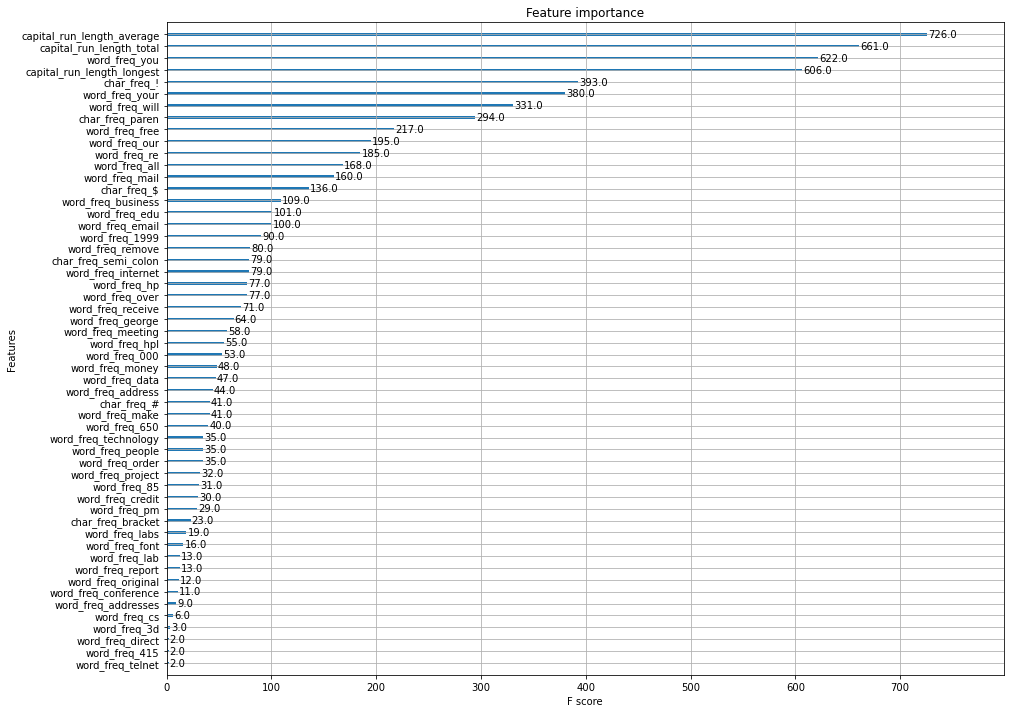

In [238]:
# create dict to use later
myfeatures = X.columns
dict_features = dict(enumerate(myfeatures))

# feat importance with names f1,f2,...
axsub = xgb.plot_importance(xgb_pipeline2['xgbm'])

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(myfeatures))
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels)
plt.show()

In [241]:
# How does the model perform when dropping the 10 least important features?
scores2 = cross_val_score(xgbm_best, X.drop(lst_yticklabels[0:10],axis=1), y, cv=4, scoring='accuracy')
print("accuracy of", scores2.mean(), 'with a standard deviation of', scores2.std())

accuracy of 0.951071806426686 with a standard deviation of 0.0064392940643185565


### Commentary
In the case of XGBoost model, dropping the least-predictive features has minimal impact on accuracy (less than 1%). While there appears no benefit in doing so, this ranking of features may be useful for performing feature selection for other models.

## KNN 

In [278]:
# Knn and Hyperparameter Tuning
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline=Pipeline([('scaler', StandardScaler()),
                      ('knn',KNeighborsClassifier())])

# search parameters
params={'knn__n_neighbors':np.arange(1,10,1),
       'knn__weights':['uniform','distance'],
       'knn__p':[1,2],
       'knn__leaf_size':np.arange(1,60,1)}

rs=RandomizedSearchCV(estimator=knn_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
rs.fit(X,y)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   param_distributions={'knn__leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59]),
                                        'knn__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='accuracy')

In [279]:
# getting results
print('best model',rs.best_estimator_)
print('best accuracy',rs.best_score_)

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(leaf_size=2, n_neighbors=6, p=1,
                                      weights='distance'))])
best accuracy 0.918052802241649


In [280]:
# How does dropping the least predictive features from XGBoost impact KNN's performance?
scores = cross_val_score(KNeighborsClassifier(leaf_size=2, n_neighbors=6, p=1, weights='distance'), X, y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

accuracy of 0.8410918108319883 with a standard deviation of 0.0024172514770058008


In [276]:
# Tuning parameters and scoring model with least important features from XGBoost dropped
# Knn and Hyperparameter Tuning
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline=Pipeline([('scaler', StandardScaler()),
                      ('knn',KNeighborsClassifier())])

# search parameters
params={'knn__n_neighbors':np.arange(1,10,1),
       'knn__weights':['uniform','distance'],
       'knn__p':[1,2]}

rs=RandomizedSearchCV(estimator=knn_pipeline,param_distributions=params,n_iter=10,scoring='accuracy',cv=4)
rs.fit(X.drop(lst_yticklabels[0:20],axis=1),y)

# getting results
print('best model',rs.best_estimator_)
print('best accuracy',rs.best_score_)

best model Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, p=1, weights='distance'))])
best accuracy 0.9178160623819687


In [277]:
# How does dropping the least predictive features from XGBoost impact KNN's performance?
scores = cross_val_score(KNeighborsClassifier(n_neighbors=4, p=1, weights='distance'), X.drop(lst_yticklabels[0:20],axis=1), y, cv=4, scoring='accuracy')
print("accuracy of", scores.mean(), 'with a standard deviation of', scores.std())

accuracy of 0.838003359945692 with a standard deviation of 0.0041136310341672745


### Knn Commentary
Feature removal did not significantly impact performance when 10 least predictive features were removed. <br>
Cross-validated accuracy decreased by 1% when 20 least predictive features were removed <br>
While the model performed worse compared to XGBoost, I hope to see if it is useful in an ensembling approach.

In [ ]:
# Naive Bayes and Hyperparameter Tuning

In [ ]:
# Feed-Forward Neural Net re: Rodan et. all

In [ ]:
# multi-model ensemble

In [ ]:
# model performance: AUC graph

In [ ]:
# Model Evaluation: cross-validation, confusion matrix, ROC curve, precision, recall, f-measure 

# Modeling: Best Cost-Sensitive Model
Using 10:1 cost ratio: <br> 
misclassifying a legitimate email as spam is 10 times more costly than classifying spam as a legitimate email

In [ ]:
# Repeat previous models, optimize for cost-sensitivity

In [ ]:
# Model Evaluation: cross-validation, confusion matrix, ROC curve, precision, recall, f-measure

In [ ]:
# Visualization of cost-sensitivity performance

# Discussion of Results
Finally, as a deliverable, produce a write-up (i.e., a single PDF file) describing your 
aforementioned explorations. <br>
Report the performances of different models that you tried (i.e., using different data mining techniques, different attribute selection techniques, etc.) <br> 
What was the performance of the best model in the cost-unaware task (i.e., in terms of accuracy)?<br>
What was the performance of the best model in the cost-aware task (i.e., in 
terms of expected cost)?<br> 
Discuss the best models in two different tasks (as well as their performance) in detail, provide some comparisons. <br>
Draw some conclusions from the assignment.   